# Honors Thesis: Progress Report Two

### Will Rodman

Since the initial progress report, I have: completed writing supporting Python classes necessary to test the Traversal Distance, collected two datasets that will be used as test data, and run the Traversal Distance on a sample of each dataset. 

The two new test datasets include: 
- Plant leafs stored as CSV files.
- English characters stored as JSON files.

The new classes added to the ```.TraversalDistance``` library include: 
- ```BinarySearch```: Uses binary search to find the min epsilon of the Traversal Distance. 
- ```Visualize```: Plots both geometric graphs, then highlights cells where free space exists. 
- ```DistanceMatrix```: Computes a distance matrix, using thr Traversal Distance as measurement, given two sets of geometric graphs. 

## Test Datasets

In [1]:
# standard library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from scipy import stats
import os
import json

# local classes
from TraversalDistance.Graph import Graph
from TraversalDistance.FreeSpaceGraph import FreeSpaceGraph
from TraversalDistance.Visualize import Visualize
from TraversalDistance.BinarySearch import BinarySearch
from TraversalDistance.DistanceMatrix import DistanceMatrix

### Loading the Leaf Dataset

In [2]:
df = pd.read_csv('leaf_data/maracuya.csv')
df = df.drop(columns=['plant', 'ontogeny', 'total'])

# divide species into seven classes based on the paper
# https://academic.oup.com/gigascience/article/6/1/giw008/2865207?login=true#supplementary-data
species_classes = {'miniata':6,
    'amethystina':3,
    'alata':5,
    'rubra':1,
    'misera':0,
    'setacea':2,
    'triloba':4,
    'nitida':5,
    'actinia':4,
    'villosa':5,
    'micropetala':1,
    'mucronata':6,
    'maliformis':6,
    'miersii':4,
    'malacophylla':6,
    'gibertii':2,
    'mollissima':2,
    'caerulea':2,
    'gracilis':3,
    'foetida':3,
    'racemosa':5,
    'tenuifila':2,
    'cristalina':6,
    'ligularis':5,
    'cincinnata':2,
    'coccinea':6,
    'hatschbachii':2,
    'morifolia':3,
    'organensis':1,
    'capsularis':1,
    'edmundoi':2,
    'galbana':6,
    'tricuspis':1,
    'pohlii':1,
    'biflora':1,
    'sidifolia':4,
    'suberosa':2,
    'edulis':5,
    'coriacea':0,
    'kermesina':2}

# replace species names with class in dataset
df['species_classes'] = df['species'].map(species_classes)


# dropping outlying heteroblasty values
lower_bound = df['heteroblasty'].quantile(0.80)
upper_bound = df['heteroblasty'].quantile(0.90)
df = df[(df['heteroblasty'] >= lower_bound) & (df['heteroblasty'] <= upper_bound)]

# printing dataframe head
print(df.shape)
df.head()

(401, 33)


,species,heteroblasty,x1,y1,x2,y2,x3,y3,x4,y4,...,y11,x12,y12,x13,y13,x14,y14,x15,y15,species_classes
2,actinia,15,-43.242816,430.053913,-39.277936,409.976781,-34.239161,376.468073,4.770596,377.631881,...,-1462.301694,546.694706,-517.910591,557.727421,-406.283139,488.911001,155.339518,460.348932,210.137903,4
3,actinia,14,-36.082509,416.832663,-30.527203,394.236217,-19.829324,359.869763,13.246641,361.064598,...,-1385.313503,535.019483,-519.980964,617.977373,-346.868643,517.511348,207.452944,483.026127,261.141674,4
4,actinia,13,-7.724386,362.852233,-18.024917,347.266408,-16.965580,316.096657,18.166718,313.986527,...,-1493.947554,572.248040,-473.575088,591.964194,-391.158971,440.811250,275.545461,392.206108,308.648330,4
17,actinia,14,-44.918266,393.241955,-56.996588,374.975493,-26.231109,360.611771,28.656493,325.944374,...,-1544.337476,581.284358,-403.004684,599.540556,-302.987351,469.789777,196.915193,426.293825,265.674601,4
18,actinia,13,-11.965128,345.150805,-12.446094,328.081630,-6.230564,303.243904,43.021996,288.773927,...,-1598.088328,593.203274,-273.829452,594.560801,-207.874561,485.547020,190.654361,434.937213,239.824699,4


In [3]:
# edges to build graph
edges = {(1, 2),
    (2, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (6, 1),
    (1, 7),
    (2, 7),
    (2, 9),
    (3, 9),
    (3, 11),
    (4, 11),
    (4, 13),
    (5, 13),
    (5, 15),
    (6, 15),
    (7, 8),
    (8, 9),
    (9, 10),
    (10, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (14, 15)
}

x_headers = [f'x{i}' for i in range(1, 16)]
y_headers = [f'y{i}' for i in range(1, 16)]

# function to convert observation into Graph object
def row_to_graph(row):
    x_row, y_row = row[x_headers], row[y_headers]     
    graph = Graph()
    graph.name = row['species']

    for i, (x_header, y_header) in enumerate(zip(x_headers, y_headers), 1):
        x, y = x_row[x_header], y_row[y_header]
        graph.addNode(i, x, y)
        
    for i, edge in enumerate(edges, 1):
        graph.connectTwoNodes(i, edge[0], edge[1])
            
    return graph

def rows_to_graphs(df, n=None):
    graphs = list() 
    if n: df = df.head(n)
    for index, row in df.iterrows():
        graph = row_to_graph(row)
        graphs.append(graph)
    return graphs

### Loading the Letter Dataset

In [4]:
def json_to_graph(json_data):    
    graph = Graph()
    graph.name = json_data['gxl']['graph'][0]['$']['id'][0]
    
    # Extract X, Y coordinates from 'node' elements.
    for node_data in json_data['gxl']['graph'][0]['node']:
        node_id = int(node_data['$']['id'][1:])
        x_coord = float(node_data['attr'][0]['float'][0])
        y_coord = float(node_data['attr'][1]['float'][0])
        graph.addNode(node_id, x_coord, y_coord)

    # Extract edges from 'edge' elements.
    for i, edge_data in enumerate(json_data['gxl']['graph'][0]['edge'], 1):
        from_node = int(edge_data['$']['from'][1:])
        to_node = int(edge_data['$']['to'][1:])
        graph.connectTwoNodes(i, from_node, to_node)
        
    return graph, graph.name

In [5]:
os.chdir('letter_data')
file_names = os.listdir("LOW")
graphs = dict()

for file_name in file_names:
    if file_name.endswith('.json'):
        try:
            json_graph = json.load(open(f"LOW/{file_name}"))
            graph, name = json_to_graph(json_graph)
            
            if name in graphs.keys():
                graphs[name].append(graph)
            else:
                graphs[name] = [graph]
                
        except Exception as error: 
            print(f"AssertionError {error}: Fail to parse {file_name}.")

AssertionError 'edge': Fail to parse VP1_0125.json.
AssertionError 'edge': Fail to parse LP1_0103.json.
AssertionError 'gxl': Fail to parse test.json.
AssertionError 'edge': Fail to parse LP1_0136.json.
AssertionError 'edge': Fail to parse LP1_0086.json.
AssertionError 'edge': Fail to parse LP1_0068.json.
AssertionError 'edge': Fail to parse VP1_0086.json.
AssertionError 'gxl': Fail to parse validation.json.
AssertionError 'gxl': Fail to parse train.json.
AssertionError 'edge': Fail to parse IP1_0110.json.


In [6]:
for key in graphs.keys():
    count = len(graphs[key])
    print(f"{key}: {count}")

T: 150
A: 150
X: 150
H: 150
Y: 150
I: 149
E: 150
N: 150
L: 146
M: 150
V: 148
Z: 150
F: 150
W: 150
K: 150


## Visualizing Graphs

### Leaf Dataset

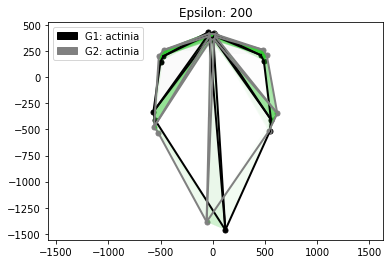

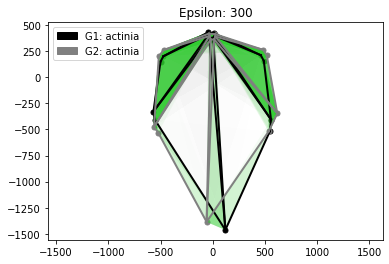

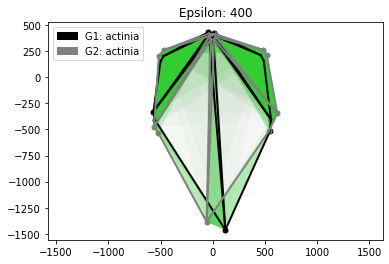

In [7]:
# first two observation example 
row_1, row_2 = df.iloc[0], df.iloc[1]
graph_1, graph_2 = row_to_graph(row_1), row_to_graph(row_2)

for epsilon in  [200, 300, 400]:
    visual = Visualize(graph_1, graph_2, epsilon=epsilon)
    visual.plot_freespace()

### Leaf Dataset

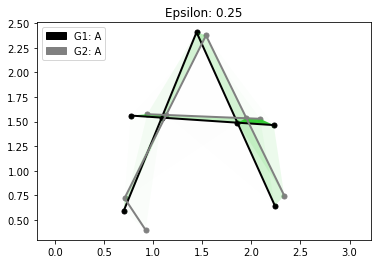

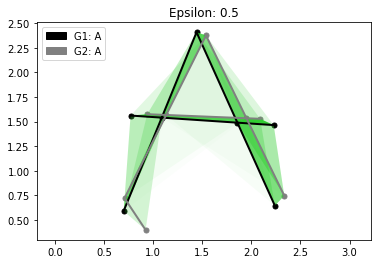

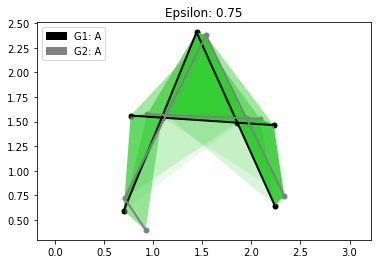

In [8]:
# first two observation example 
graph_3, graph_4 = graphs['A'][0], graphs['A'][1]

for epsilon in [0.25, 0.5, 0.75]:
    visual = Visualize(graph_3, graph_4, epsilon=epsilon)
    visual.plot_freespace()

## Binary Search

### Leaf Dataset and Letter Dataset

In [9]:
def print_epsilon(g1, g2):

    # comparing two identical graphs
    binary_search = BinarySearch(g1, g2, left=0, right=500, precision=0.01)
    epsilon = binary_search.search()
    print("Computing graph_1 by graph_1 (traversed) minimum epsilon:", epsilon)

    # comparing graph two and graph one
    binary_search = BinarySearch(g2, g1, left=0, right=500, precision=0.01)
    epsilon = binary_search.search()
    print("Computing graph_2 by graph_1 (traversed) minimum epsilon:", epsilon)

    # comparing graph one and graph two
    binary_search = BinarySearch(g1, g2, left=0, right=500, precision=0.01)
    epsilon = binary_search.search()
    print("Computing graph_1 by graph_2 (traversed) minimum epsilon:", epsilon)

In [10]:
print_epsilon(graph_1, graph_2)

Computing graph_1 by graph_1 (traversed) minimum epsilon: 180.2978515625
Computing graph_2 by graph_1 (traversed) minimum epsilon: 365.02838134765625
Computing graph_1 by graph_2 (traversed) minimum epsilon: 180.2978515625


In [11]:
print_epsilon(graph_3, graph_4)

Computing graph_1 by graph_1 (traversed) minimum epsilon: 0.1068115234375
Computing graph_2 by graph_1 (traversed) minimum epsilon: 0.1068115234375
Computing graph_1 by graph_2 (traversed) minimum epsilon: 0.1068115234375


## Computing Distance Matrix

### Leaf Dataset

In [12]:
def scatter_plot(xy_1, xy_2, class_1, class_2):
    x_1, y_1 = zip(*xy_1)
    x_2, y_2 = zip(*xy_2)
    label_1 = f"C1: {class_1} | C2: {class_1}"
    label_2 = f"C1: {class_1} | C2: {class_2}"
    
    plt.scatter(x_1, y_1, c='blue', marker='o', label=label_1, alpha=0.5, s=15)
    plt.scatter(x_2, y_2, c='red', marker='o', label=label_2, alpha=0.5, s=15)   

    plt.title('Traversal Distances for Two Classifications')
    plt.ylabel(f'Minium Epsilon (C1 Traversed)')
    plt.xlabel(f'Minium Epsilon (C2 Traversed)')

    plt.legend()
    plt.show()

In [13]:
n = 15
class_1, class_2 = 'actinia', 'cristalina'

class_1_df = df[df['species'] == class_1]
class_1_graphs = rows_to_graphs(class_1_df, n=n)

class_2_df = df[df['species'] == class_2]
class_2_graphs = rows_to_graphs(class_2_df, n=n)

class_1_1_matrix = DistanceMatrix(class_1_graphs, class_1_graphs)
class_1_2_matrix = DistanceMatrix(class_1_graphs, class_2_graphs)

class_1_1_matrix.compute()
class_1_2_matrix.compute()

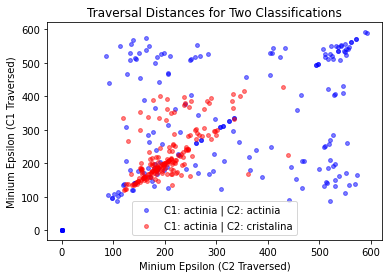

In [14]:
scatter_plot(class_1_1_matrix.to_list(), class_1_2_matrix.to_list(), class_1, class_2)

### Letter Dataset

In [15]:
n = 15
class_3, class_4 = 'T', 'Y'

class_3_graphs = graphs['A'][:n]
class_4_graphs = graphs['Y'][:n]

class_3_3_matrix = DistanceMatrix(class_3_graphs, class_3_graphs, left=0, right=5, precision=0.01)
class_3_4_matrix = DistanceMatrix(class_3_graphs, class_4_graphs, left=0, right=5, precision=0.01)

class_3_3_matrix.compute()
class_3_4_matrix.compute()

Exception: float division by zero.
Exception: math domain error.
Exception: float division by zero.
Exception: float division by zero.
Exception: math domain error.
Exception: math domain error.
Exception: float division by zero.
Exception: float division by zero.
Exception: math domain error.
Exception: math domain error.
Exception: math domain error.
Exception: float division by zero.
Exception: math domain error.
Exception: math domain error.


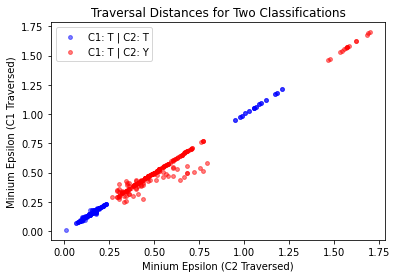

In [16]:
scatter_plot(class_3_3_matrix.to_list(), class_3_4_matrix.to_list(), class_3, class_4)